## Dataset
For this part of the assignment, you will be working with the CIFAR100 dataset (already loaded above). This dataset consists of 60K 32x32 color images from 100 classes, with 600 images per class. There are 50K training images and 10K test images. The images in CIFAR100 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels.
## BaseNet
We created a BaseNet that you can run and get a baseline accuracy

## Goal
Your goal is to edit the BaseNet class or make new classes for devising **a effective（accuracy & Floats & Params） deep net architecture** through what you have learned in this course

## Submission
**Before due**，submitting your work to **aleeyanger@163.com**
Attention:
YOUR FILE SHOULDE BE LIKE THIS

```
  FINAL_(YOUR_TREAM_NUMBER).zip:
      --Report.pdf
      --code.zip
```
  EXAMPLE:
`  T1G1.zip`




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##BASELINE MODEL

In [ ]:
#Device check and load model into device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#install thop for count PARAMS and Flops
! pip install thop
! pip install torchprofile 1>/dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade jupyterhub
!pip install --upgrade --user nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 6.0 MB/s 
     |████████████████████████████████| 210 kB 78.9 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 57 kB 7.0 MB/s 
     |████████████████████████████████| 109 kB 74.0 MB/s 
     |████████████████████████████████| 4.0 MB 47.2 MB/s 
     |████████████████████████████████| 555 kB 78.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 273 kB 5.4 MB/s 
     |████████████████████████████████| 133 kB 57.8 MB/s 
     |████████████████████████████████| 71 kB 247 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location

In [ ]:
import pandas as pd
import os
import torch
import time
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import *

import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available()

##HYPER-PARAM
batch_size = 400
epochs = 120
max_lr = 0.001
grad_clip = 0.01
weight_decay =0.001
opt_func = torch.optim.Adam

##DOWNLOAD dataset
train_data = torchvision.datasets.CIFAR100('./', train=True, download=True)
# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

##TRANSFORM
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])
##DATASET and DATALOADER
trainset = torchvision.datasets.CIFAR100("./",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size, shuffle=True, num_workers=2,pin_memory=True)

testset = torchvision.datasets.CIFAR100("./",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size*2 ,pin_memory=True, num_workers=2)
#LOADER
device = get_default_device()
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
from PIL import Image
class Grid(object):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        self.d1 = d1
        self.d2 = d2
        self.rotate = rotate
        self.ratio = ratio
        self.mode=mode
        self.st_prob = self.prob = prob
       # self.diffusion=DenoiseDiffusion(
      #      n_steps=100,Device=device
      #  )
    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * min(1, epoch / max_epoch)

    def __call__(self, img):
              
        #batch_size = img.shape[0]
        #T = torch.randint(0, int(self.ratio*100), (1,), device=device, dtype=torch.long)
        if np.random.rand() > self.prob:
            return img
        h = img.size(1)
        w = img.size(2)
        
        # 1.5 * h, 1.5 * w works fine with the squared images
        # But with rectangular input, the mask might not be able to recover back to the input image shape
        # A square mask with edge length equal to the diagnoal of the input image 
        # will be able to cover all the image spot after the rotation. This is also the minimum square.
        hh = math.ceil((math.sqrt(h*h + w*w)))
        
        d = np.random.randint(self.d1, self.d2)
        #d = self.d
        
        # maybe use ceil? but i guess no big difference
        self.l = math.ceil(d*self.ratio)#grid size
        
        mask = np.ones((hh, hh), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        for i in range(-1, hh//d+1):
                s = d*i + st_h
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[s:t,:] *= 0
        for i in range(-1, hh//d+1):
                s = d*i + st_w
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[:,s:t] *= 0
        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        mask = mask[(hh-h)//2:(hh-h)//2+h, (hh-w)//2:(hh-w)//2+w]

        mask = torch.from_numpy(mask).float()
        mask=mask.to(device)
        if self.mode == 1:
            mask = 1-mask

        mask = mask.expand_as(img)
        #img=self.diffusion.q_sample(img,T)
        img = img * mask 
        return img

class GridMask(nn.Module):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        super(GridMask, self).__init__()
        self.rotate = rotate
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.grid = Grid(d1, d2, rotate, ratio, mode, prob)

    def set_prob(self, epoch, max_epoch):
        self.grid.set_prob(epoch, max_epoch)

    def forward(self, x):
        if not self.training:
            return x
        n,c,h,w = x.size()
        y = []
        for i in range(n):
            y.append(self.grid(x[i]))
        y = torch.cat(y).view(n,c,h,w)
        return y


In [ ]:
!cp -a /content/drive/MyDrive/group22_augumentate_model.h5 /content

In [ ]:
##TRAINING SETUP

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
#for adaptive data augumentation,we need to pass
#the epoc to the training function
#Here,i use the method from the diffusion gan to adjust the ratio of grid mask
class ImageClassificationBase(nn.Module):
    def training_step(self, batch,enpoch):
        images, labels = batch
        if args.grid:
          grid.set_prob(enpoch, args.st_epochs)
          imagew=grid(images)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        batch_size=images.shape[0]
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
#NET
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

   
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028 
                                        nn.Linear(1028, num_classes)) # 1028 -> 100
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, 100), device)


In [ ]:
#SEE YOUR MODEL
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
#Training Setup
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(term,epochs, max_lr, model, train_loader, test_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch,30*term+epoch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
import argparse

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--d1', type=int, default=12,help='d1')
parser.add_argument('--d2', type=int, default=28,help='d2')
parser.add_argument('--rotate', type=int, default=360,help='rotate the mask')
parser.add_argument('--ratio', type=float, default=0.4,help='keep ratio')
parser.add_argument('--mode', type=int, default=1,
                    help='GridMask (1) or revised GridMask (0)')
parser.add_argument('--prob', type=float, default=0.8,
                    help='max prob')
parser.add_argument('--grid', action='store_true', default=True,
                        help='apply grid')
parser.add_argument('--st_epochs', type=float, default=100,
    help='epoch when archive max prob')
args = parser.parse_args()

## **if you have pretrained model run this else run the training code**

In [ ]:
#!cp -a /content/drive/MyDrive/group22_augumentate_model.h5  /content/group22_augumentate_model.h5 
checkpoint = torch.load('group22_augumentate_model.h5', map_location="cpu")
model = ResNet9(3, 100)
model.cuda()
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
#grid mask
if args.grid:
  grid = GridMask(args.d1,args.d2, args.rotate, args.ratio,args.mode,args.prob)
#Training(Using Multi_LR)
history =[evaluate(model, testloader)] ## Initial evaluation
# Fitting the first 1/4 
current_time=time.time()
'''
history += fit_one_cycle(0,int(epochs/4), max_lr, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
# Fitting the first 2/4 epochs
history += fit_one_cycle(1,int(epochs/4), max_lr/10, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
# Fitting the first 3/4 
history += fit_one_cycle(2,int(epochs/4), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
'''
# Fitting the first 4/4 epochs
history += fit_one_cycle(3,int(epochs/4), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
# Print training time
time_train = time.time() - current_time
print('Training time: {:.2f} s'.format(time_train))
torch.save(model.state_dict(), 'group22_augumentate_model_diffusion.h5')

KeyboardInterrupt: ignored

In [ ]:
# Collect training time and result
current_time = time.time()
result = evaluate(model, testloader)
result
time_inference = time.time() - current_time
print('Inference time: {:.2f} s'.format(time_inference))


Inference time: 6.53 s


In [ ]:
#
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

y_test, y_pred = test_label_predictions(model, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[87  0  1 ...  0  0  0]
 [ 0 90  0 ...  0  0  0]
 [ 0  0 63 ...  0  2  0]
 ...
 [ 0  1  0 ... 84  0  0]
 [ 0  0  2 ...  0 58  0]
 [ 0  0  0 ...  0  0 79]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       100
           1       0.84      0.90      0.87       100
           2       0.67      0.63      0.65       100
           3       0.71      0.59      0.64       100
           4       0.58      0.66      0.62       100
           5       0.81      0.79      0.80       100
           6       0.78      0.78      0.78       100
           7       0.72      0.76      0.74       100
           8       0.90      0.88      0.89       100
           9       0.84      0.85      0.85       100
          10       0.65      0.62      0.63       100
          11       0.46      0.51      0.48       100
          12       0.82      0.81      0.81       100
          13       0.77      0.73      0.75       100
          14   

 You must report your **MODEL NET ,Train Time,Inference Time(Test Time),Parameters Size&Flops,Accuary on Test Datest**

In [ ]:
#MODEl NET
checkpoint = torch.load('group22_augumentate_model.h5', map_location="cpu")
model = ResNet9(3, 100)
model.load_state_dict(checkpoint)
recover_model = lambda : model.load_state_dict(checkpoint)
model.cuda()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
#Train Time
print('Training time: {:.2f} s'.format(time_train))

In [ ]:
#Inference Time (Test Time)
print('Inference time: {:.2f} s'.format(time_inference))

Inference time: 6.53 s


In [ ]:
#Paramater Size and FLOPS
from thop import profile
 
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, params = profile(model, inputs=(input,))
print(flops)
print(params)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
532846480.0
30441528.0


In [ ]:
#Accuaray
print('Accuracy score: %f' % accuracy)

Accuracy score: 0.749700


# **Pruning**

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader, 
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0
  current_time=time.time()
  for inputs, targets in tqdm(dataloader, desc="eval", leave=False, 
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)
    
    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()
  print("inference time:",time.time()-current_time)
  return (num_correct / num_samples * 100).item()

In [ ]:
dense_model_accuracy = evaluate(model, testloader)
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
from thop import profile
 
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, _= profile(model, inputs=(input,))
print(f"dense model has flops={flops:.2f}")



eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 10.707481384277344
dense model has accuracy=74.97%
dense model has size=116.13 MiB
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
dense model has flops=532846480.00


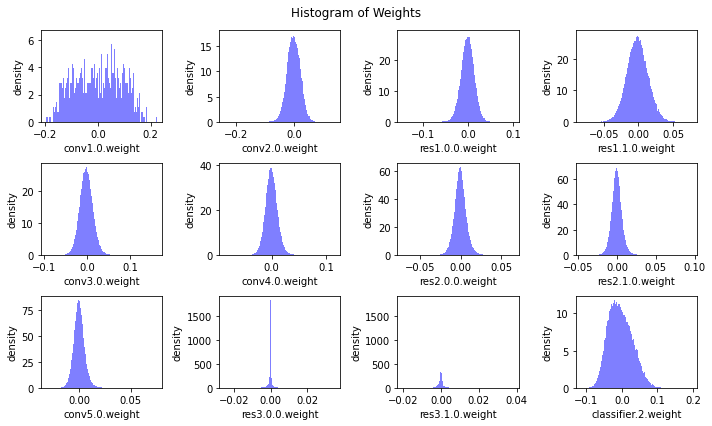

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,4, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = tensor.abs()
    # Step 3: calculate the pruning threshold
    threshold = importance.view(-1).kthvalue(num_zeros).values
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold)

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model,testloader, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/12 weight - conv1.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.6086325645446777
    sparsity=0.40: accuracy=55.33%inference time: 2.5813839435577393
    sparsity=0.50: accuracy=36.56%inference time: 2.595581293106079
    sparsity=0.60: accuracy=25.93%inference time: 2.586395740509033
    sparsity=0.70: accuracy=12.15%inference time: 2.6066300868988037
    sparsity=0.80: accuracy=6.08%inference time: 2.635244131088257
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[55.33%, 36.56%, 25.93%, 12.15%, 6.08%, 2.48%]

scanning 1/12 weight - conv2.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.640061616897583
    sparsity=0.40: accuracy=74.81%inference time: 2.6379618644714355
    sparsity=0.50: accuracy=74.66%inference time: 2.656883478164673
    sparsity=0.60: accuracy=73.32%inference time: 2.647733211517334
    sparsity=0.70: accuracy=70.60%inference time: 2.68745756149292
    sparsity=0.80: accuracy=63.05%inference time: 2.6639058589935303
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.81%, 74.66%, 73.32%, 70.60%, 63.05%, 35.59%]

scanning 2/12 weight - res1.0.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.724283456802368
    sparsity=0.40: accuracy=74.84%inference time: 2.6708827018737793
    sparsity=0.50: accuracy=74.65%inference time: 2.7172317504882812
    sparsity=0.60: accuracy=74.13%inference time: 2.6961352825164795
    sparsity=0.70: accuracy=73.06%inference time: 2.68734073638916
    sparsity=0.80: accuracy=69.16%inference time: 2.707475185394287
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.84%, 74.65%, 74.13%, 73.06%, 69.16%, 56.52%]

scanning 3/12 weight - res1.1.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.6887123584747314
    sparsity=0.40: accuracy=74.77%inference time: 2.685838460922241
    sparsity=0.50: accuracy=74.80%inference time: 2.6651554107666016
    sparsity=0.60: accuracy=74.46%inference time: 2.6703197956085205
    sparsity=0.70: accuracy=72.89%inference time: 2.6714422702789307
    sparsity=0.80: accuracy=66.92%inference time: 2.616793632507324
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.77%, 74.80%, 74.46%, 72.89%, 66.92%, 44.46%]

scanning 4/12 weight - conv3.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.6487181186676025
    sparsity=0.40: accuracy=74.65%inference time: 2.6538290977478027
    sparsity=0.50: accuracy=73.89%inference time: 2.6715986728668213
    sparsity=0.60: accuracy=71.26%inference time: 2.645218849182129
    sparsity=0.70: accuracy=64.30%inference time: 2.6450271606445312
    sparsity=0.80: accuracy=42.60%inference time: 2.6298673152923584
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.65%, 73.89%, 71.26%, 64.30%, 42.60%, 11.31%]

scanning 5/12 weight - conv4.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.6818487644195557
    sparsity=0.40: accuracy=74.64%inference time: 3.0189876556396484
    sparsity=0.50: accuracy=74.56%inference time: 2.657437324523926
    sparsity=0.60: accuracy=73.68%inference time: 2.643070697784424
    sparsity=0.70: accuracy=71.49%inference time: 2.6800787448883057
    sparsity=0.80: accuracy=65.27%inference time: 2.6696419715881348
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.64%, 74.56%, 73.68%, 71.49%, 65.27%, 40.52%]

scanning 6/12 weight - res2.0.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.6923513412475586
    sparsity=0.40: accuracy=74.95%inference time: 2.6883246898651123
    sparsity=0.50: accuracy=74.93%inference time: 2.678142786026001
    sparsity=0.60: accuracy=74.51%inference time: 2.700430393218994
    sparsity=0.70: accuracy=73.43%inference time: 2.684323310852051
    sparsity=0.80: accuracy=70.02%inference time: 2.6927428245544434
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.95%, 74.93%, 74.51%, 73.43%, 70.02%, 54.08%]

scanning 7/12 weight - res2.1.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.708702802658081
    sparsity=0.40: accuracy=74.97%inference time: 2.704982280731201
    sparsity=0.50: accuracy=74.86%inference time: 2.7178914546966553
    sparsity=0.60: accuracy=74.86%inference time: 2.6738650798797607
    sparsity=0.70: accuracy=74.57%inference time: 2.686830997467041
    sparsity=0.80: accuracy=73.64%inference time: 2.7047061920166016
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.97%, 74.86%, 74.86%, 74.57%, 73.64%, 70.72%]

scanning 8/12 weight - conv5.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.6662120819091797
    sparsity=0.40: accuracy=74.91%inference time: 2.6687796115875244
    sparsity=0.50: accuracy=74.91%inference time: 2.6485755443573
    sparsity=0.60: accuracy=74.99%inference time: 2.6686267852783203
    sparsity=0.70: accuracy=74.89%inference time: 2.651968002319336
    sparsity=0.80: accuracy=74.40%inference time: 2.6507437229156494
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.91%, 74.91%, 74.99%, 74.89%, 74.40%, 72.08%]

scanning 9/12 weight - res3.0.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.6773247718811035
    sparsity=0.40: accuracy=74.83%inference time: 2.6326491832733154
    sparsity=0.50: accuracy=74.82%inference time: 2.6206374168395996
    sparsity=0.60: accuracy=74.85%inference time: 2.6567440032958984
    sparsity=0.70: accuracy=74.79%inference time: 2.640711545944214
    sparsity=0.80: accuracy=74.93%inference time: 2.6439311504364014
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.83%, 74.82%, 74.85%, 74.79%, 74.93%, 74.96%]

scanning 10/12 weight - res3.1.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.644940137863159
    sparsity=0.40: accuracy=74.83%inference time: 2.6796319484710693
    sparsity=0.50: accuracy=74.82%inference time: 2.6463654041290283
    sparsity=0.60: accuracy=74.82%inference time: 2.635780096054077
    sparsity=0.70: accuracy=74.82%inference time: 2.67016339302063
    sparsity=0.80: accuracy=74.82%inference time: 2.6706085205078125
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.83%, 74.82%, 74.82%, 74.82%, 74.82%, 74.83%]

scanning 11/12 weight - classifier.2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

inference time: 2.677683115005493
    sparsity=0.40: accuracy=74.77%inference time: 2.691439151763916
    sparsity=0.50: accuracy=74.70%inference time: 2.682107925415039
    sparsity=0.60: accuracy=74.58%inference time: 2.669373035430908
    sparsity=0.70: accuracy=74.08%inference time: 2.6671805381774902
    sparsity=0.80: accuracy=72.43%inference time: 2.70658016204834
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[74.77%, 74.70%, 74.58%, 74.08%, 72.43%, 66.75%]

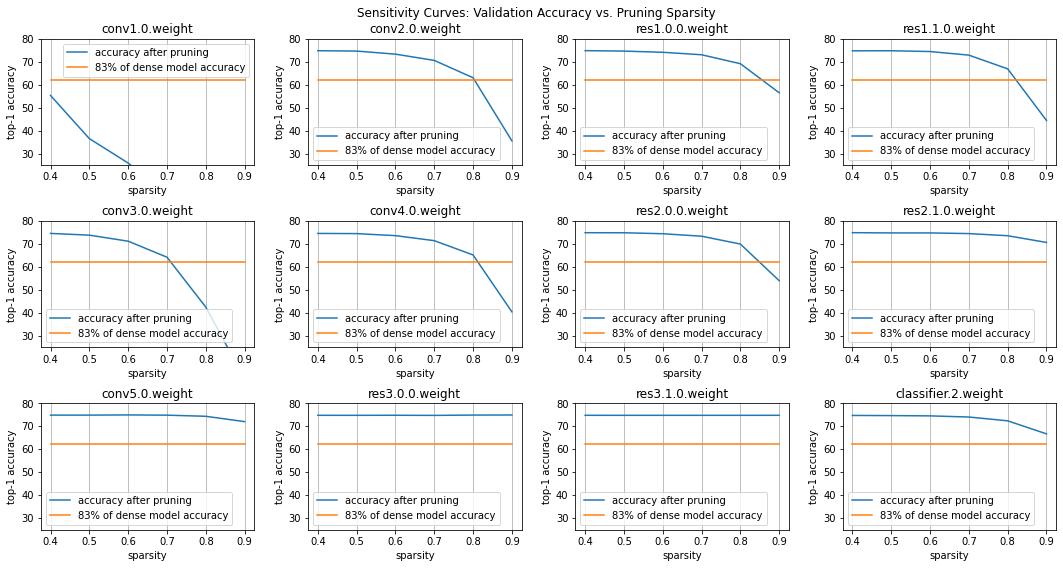

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy =100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(25, 80)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()
plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

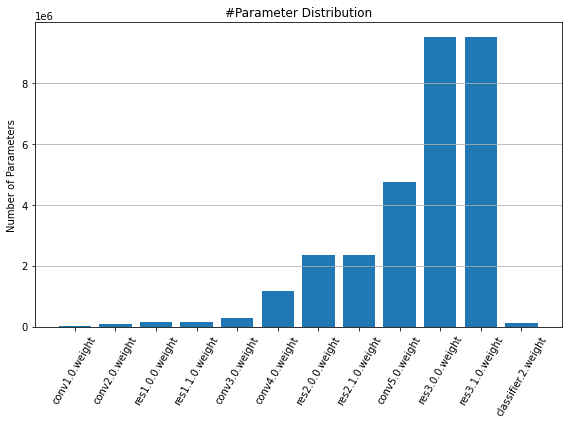

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [ ]:
recover_model()

sparsity_dict = {
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'conv1.0.weight': 0.40,
    'conv2.0.weight': 0.8,
    'res1.0.0.weight':0.85,
    'res1.1.0.weight':0.85,
    'conv3.0.weight': 0.7,
    'conv4.0.weight': 0.8,
    'conv5.0.weight': 0.9,
    'res2.0.0.weight': 0.85,
    'res2.1.0.weight': 0.9,
    'res3.0.0.weight': 0.9,
    'res3.1.0.weight': 0.9,
    'classifier.2.weight': 0.9
}

After pruning with sparsity dictionary
  conv1.0.weight: 0.40
  conv2.0.weight: 0.80
  res1.0.0.weight: 0.85
  res1.1.0.weight: 0.85
  conv3.0.weight: 0.70
  conv4.0.weight: 0.80
  conv5.0.weight: 0.90
  res2.0.0.weight: 0.85
  res2.1.0.weight: 0.90
  res3.0.0.weight: 0.90
  res3.1.0.weight: 0.90
  classifier.2.weight: 0.90
The sparsity of each layer becomes
  conv1.0.weight: 0.40
  conv2.0.weight: 0.80
  res1.0.0.weight: 0.85
  res1.1.0.weight: 0.85
  conv3.0.weight: 0.70
  conv4.0.weight: 0.80
  res2.0.0.weight: 0.85
  res2.1.0.weight: 0.90
  conv5.0.weight: 0.90
  res3.0.0.weight: 0.90
  res3.1.0.weight: 0.90
  classifier.2.weight: 0.90
Sparse model has size=12.88 MiB = 11.09% of dense model size


eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 6.0515992641448975
Sparse model has accuracy=72.93% before fintuning


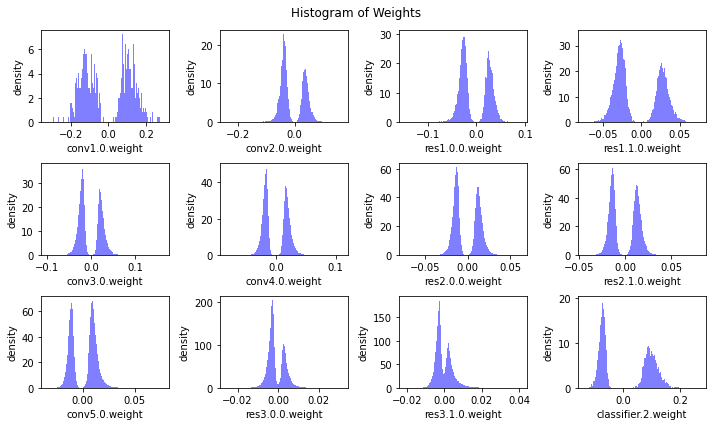

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, testloader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask 
    #    to keep the model sparse during the training
    train(model, trainloader, criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model,testloader)
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/125 [00:00<?, ?it/s]

eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.649954319000244
    Epoch 1 Accuracy 71.93% / Best Accuracy: 71.93%


train:   0%|          | 0/125 [00:00<?, ?it/s]

eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.83024525642395
    Epoch 2 Accuracy 72.95% / Best Accuracy: 72.95%


train:   0%|          | 0/125 [00:00<?, ?it/s]

eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.757984161376953
    Epoch 3 Accuracy 71.62% / Best Accuracy: 72.95%


train:   0%|          | 0/125 [00:00<?, ?it/s]

eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.7527363300323486
    Epoch 4 Accuracy 72.93% / Best Accuracy: 72.95%


train:   0%|          | 0/125 [00:00<?, ?it/s]

eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.7653377056121826
    Epoch 5 Accuracy 72.93% / Best Accuracy: 72.95%


In [ ]:
from thop import profile
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model,testloader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, _ = profile(model, inputs=(input,))
print(f"Sparse model has flops={flops:.2f}")


Sparse model has size=12.88 MiB = 11.09% of dense model size


eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.7269201278686523
Sparse model has accuracy=72.65% after fintuning
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Sparse model has flops=532846480.00


After pruning with sparsity dictionary
  conv1.0.weight: 0.40
  conv2.0.weight: 0.80
  res1.0.0.weight: 0.85
  res1.1.0.weight: 0.85
  conv3.0.weight: 0.70
  conv4.0.weight: 0.80
  conv5.0.weight: 0.90
  res2.0.0.weight: 0.85
  res2.1.0.weight: 0.90
  res3.0.0.weight: 0.90
  res3.1.0.weight: 0.90
  classifier.2.weight: 0.90
The sparsity of each layer becomes
  conv1.0.weight: 0.40
  conv2.0.weight: 0.80
  res1.0.0.weight: 0.85
  res1.1.0.weight: 0.85
  conv3.0.weight: 0.70
  conv4.0.weight: 0.80
  res2.0.0.weight: 0.85
  res2.1.0.weight: 0.90
  conv5.0.weight: 0.90
  res3.0.0.weight: 0.90
  res3.1.0.weight: 0.90
  classifier.2.weight: 0.90
Sparse model has size=12.88 MiB = 11.09% of dense model size


eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 5.073027610778809
Sparse model has accuracy=72.93% after fintuning


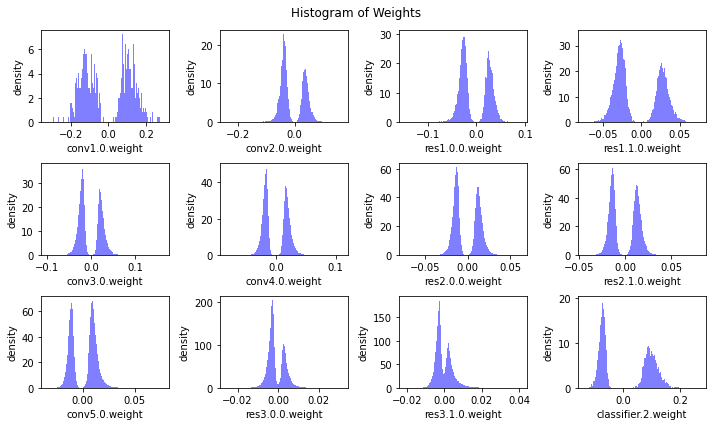

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, testloader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

# **Quantization**

In [ ]:
! pip install fast-pytorch-kmeans 1>/dev/null

In [ ]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from torchprofile import profile_macs

assert torch.cuda.is_available()

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0
  current_time=time.time()
  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()
  print("inference time:",time.time()-current_time)
  return (num_correct / num_samples * 100).item()

In [ ]:
recover_model = lambda : model.load_state_dict(best_sparse_model_checkpoint['state_dict']) #model.load_state_dict(checkpoint,strict=False)

In [ ]:
from thop import profile
fp32_model_accuracy = evaluate(model, testloader)
fp32_model_size = get_model_size(model,count_nonzero_only=True)
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, _ = profile(model, inputs=(input,))
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")
print(f"fp32 model has flops={flops:.2f}")

eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 4.269630193710327
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
fp32 model has accuracy=72.65%
fp32 model has size=12.88 MiB
fp32 model has flops=532846480.00


In [ ]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

In [ ]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        # get number of clusters based on the quantization precision
        # hint: one line of code
        n_clusters = 1 << bitwidth#位运算
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)#initialize k-means method
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)#k-means predict
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)#write the centroids to codebook
    # decode the codebook into k-means quantized tensor for inference
    quantized_tensor = codebook.centroids[codebook.labels]
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

In [ ]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)
    
    @torch.no_grad()
    def apply(self, model, update_centroids):#for every parameter in the model
        for name, param in model.named_parameters():#update codebook or create a codebook
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [ ]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, testloader)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=29.03 MiB


eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.7916557788848877
    8-bit k-means quantized model has accuracy=70.97%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=14.52 MiB


eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.7614541053771973
    4-bit k-means quantized model has accuracy=1.00%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=7.26 MiB


eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.72578763961792
    2-bit k-means quantized model has accuracy=1.00%


In [ ]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor] 
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
        codebook.centroids[k] = fp32_tensor[codebook.labels == k].mean()

In [ ]:
def naive_train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers
from thop import profile
for bitwidth in [8]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth,count_nonzero_only=True)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, testloader)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            naive_train(model, trainloader, criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, testloader)
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
        input = torch.randn(1, 3, 32, 32)
        input = input.to(device)
        flops, _ = profile(model, inputs=(input,))
        print(f"{bitwidth}-bit model has flops={flops:.2f}") 
    else:
        input = torch.randn(1, 3, 32, 32)
        input = input.to(device)
        flops, _ = profile(model, inputs=(input,))
        print(f"{bitwidth}-bit model has flops={flops:.2f}")
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=29.03 MiB


eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.65396785736084
    8-bit k-means quantized model has accuracy=69.33% before quantization-aware training 
        Quantization-aware training due to accuracy drop=3.32% is larger than threshold=0.50%


train:   0%|          | 0/125 [00:00<?, ?it/s]

eval:   0%|          | 0/13 [00:00<?, ?it/s]

inference time: 2.7533233165740967
        Epoch 0 Accuracy 73.33% / Best Accuracy: 73.33%
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
8-bit model has flops=532846480.00


In [ ]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

y_test, y_pred = test_label_predictions(model, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[85  1  0 ...  0  0  0]
 [ 0 89  0 ...  0  0  0]
 [ 1  0 61 ...  0  2  0]
 ...
 [ 0  0  0 ... 85  0  0]
 [ 0  1  2 ...  0 58  0]
 [ 0  0  0 ...  0  0 71]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       100
           1       0.79      0.89      0.84       100
           2       0.64      0.61      0.63       100
           3       0.71      0.55      0.62       100
           4       0.57      0.64      0.60       100
           5       0.76      0.74      0.75       100
           6       0.81      0.82      0.82       100
           7       0.76      0.78      0.77       100
           8       0.86      0.83      0.84       100
           9       0.81      0.83      0.82       100
          10       0.60      0.60      0.60       100
          11       0.47      0.53      0.50       100
          12       0.82      0.81      0.81       100
          13       0.65      0.69      0.67       100
          14   

## **(Optional)Some Results you can use in your Report**

In [ ]:
# Plot classification report and save to pdf function
def plot_classification(precision, recall, f1_score):
    plt.rcParams['font.size'] = 12
    plt.rc('axes', linewidth=1.75)
    marker_size = 8
    figsize = 6
    plt.figure(figsize=(1.4 * figsize, figsize))
    plt.subplot(3, 1, 1)
    plt.plot(precision, 'o', markersize=marker_size)
    plt.ylabel('Precision', fontsize=14)
    plt.xticks([])
    plt.subplot(3, 1, 2)
    plt.plot(recall, 'o', markersize=marker_size)
    plt.ylabel('Recall', fontsize=14)
    plt.xticks([])
    plt.subplot(3, 1, 3)
    plt.plot(f1_score, 'o', markersize=marker_size)
    plt.ylabel('F1-score', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.subplots_adjust(hspace=0.001)
    plt.tight_layout()
    plt.savefig("result.pdf")
# Plot classification report and save to pdf
def plot_confusion_matrix(cm):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.colorbar()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()
    plt.savefig("confusion_matrix.pdf")
    plt.show()

In [ ]:
# Plot and save confusion matrix
precision, recall, f1,_= precision_recall_fscore_support(y_test, y_pred)
print(recall)
plot_classification(precision, recall, f1)

# Plot confusion matrix
plot_confusion_matrix(cm)

NameError: ignored